**Importations**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, LassoCV

**Données**

In [2]:
data = pd.read_csv('house_price.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


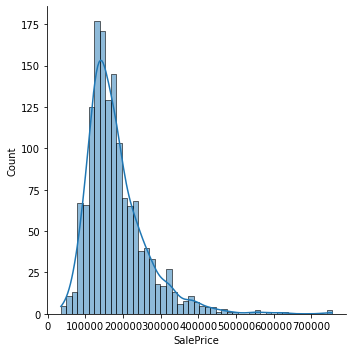

In [3]:
# Répartition de la variable cible :
sns.displot(data['SalePrice'], kde = True);

**Preprocessing**

In [4]:
# On normalise la variable cible :
#data["SalePrice"] = np.log1p(data["SalePrice"])
#sns.displot(data['SalePrice'], kde = True);

In [5]:
# On pare au plus pressé et on remplace les valeurs manquantes par la médiane :
data = data.fillna(data.median())

In [6]:
# On normalise les données numériques :
data_num = data._get_numeric_data()
scaler = StandardScaler().fit(data_num)
data_num[data_num.columns] = pd.DataFrame(scaler.transform(data_num))

In [7]:
# On encode les variables catégorielles :
data_cat = data.select_dtypes(include=object)
data_cat = pd.get_dummies(data_cat)

In [8]:
data = data_cat.join(data_num)

In [9]:
data.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0,0,0,1,0,0,1,0,0,0,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273
1,0,0,0,1,0,0,1,0,0,0,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288
2,0,0,0,1,0,0,1,0,0,1,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154
3,0,0,0,1,0,0,1,0,0,1,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281
4,0,0,0,1,0,0,1,0,0,1,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843


**Séparation des données**

In [10]:
target = data['SalePrice']
feats = data.drop('SalePrice', axis = 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2)

**Modélisation**

In [12]:
# Fonction qui retourne la MAE sur cross validation :
def scoring_cv(model):
    return - cross_val_score(model, X_train, y_train, cv = 7, scoring = 'neg_mean_absolute_error').mean()

Ridge

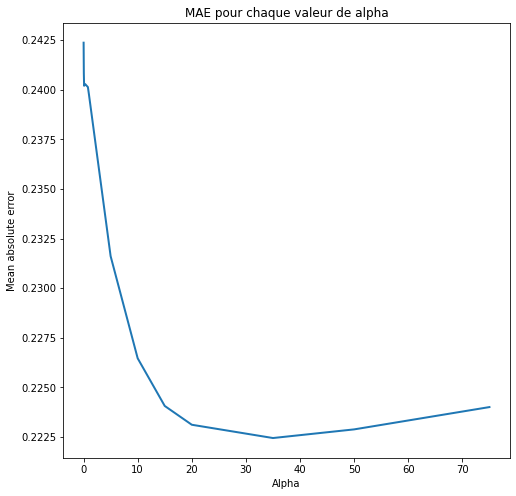

In [13]:
# MAE retournée par la fonction scoring_cv, appliquée à un modèle Ridge pour plusieurs valeurs :
alphas = [0.01, 0.05, 0.1, 0.3, 0.8, 1, 5, 10, 15, 20, 35, 50, 75]

plt.figure(figsize = (8, 8))

liste_scores = []
for alpha in alphas:
    ridge = Ridge(alpha)
    ridge.fit(X_train, y_train)
    liste_scores.append(scoring_cv(ridge))

plt.plot(alphas, liste_scores, linewidth = 2)
plt.xlabel('Alpha')
plt.ylabel('Mean absolute error')
plt.title('MAE pour chaque valeur de alpha');

In [14]:
min(liste_scores)

0.22245276402978534

In [15]:
# D'après le graphique, on choisit alpha = 50 (on minimise le MAE)
ridge_best = Ridge(alpha = 35)
ridge_best.fit(X_train, y_train)
ridge_pred_train = ridge_best.predict(X_train)
ridge_pred_test = ridge_best.predict(X_test)

In [16]:
ridge_best.score(X_test, y_test)

0.9034205419882546

In [17]:
print(mean_squared_error(ridge_pred_train, y_train, squared = False))
print(mean_squared_error(ridge_pred_test, y_test, squared = False))
# L'écart d'erreur est assez peu significatif entre l'échantillon d'entraînement et de test
# on en conclut que le modèle n'overfit pas trop sur les données d'apprentissage

0.34658788351109165
0.3178949859781035


LassoCV

In [18]:
lasso = LassoCV(alphas = [10, 1, 0.1, 0.001, 0.04, 0.0005])
lasso.fit(X_train, y_train)

LassoCV(alphas=[10, 1, 0.1, 0.001, 0.04, 0.0005])

In [19]:
scoring_cv(lasso)

0.21135490450793074

In [20]:
pred_test = lasso.predict(X_test)
lasso.score(X_test, y_test)

0.9199517982040482

In [21]:
# Nombres de variables gardées et éliminées par LassoCV :
l = []
for i in lasso.coef_:
    if i != 0:
        l.append(i)
print('Nombre de variables gardées :',len(l))
print('Nombre de variables éliminées :',len(lasso.coef_) - len(l))        

Nombre de variables gardées : 119
Nombre de variables éliminées : 170


In [22]:
# 20 variables les plus importantes selon LassoCV :
X_train.columns.sort_values(key = abs(lasso.coef_).all(), ascending = False)[:21]

Index(['YrSold', 'YearRemodAdd', 'YearBuilt', 'WoodDeckSF', 'Utilities_NoSeWa',
       'Utilities_AllPub', 'TotalBsmtSF', 'TotRmsAbvGrd', 'Street_Pave',
       'Street_Grvl', 'ScreenPorch', 'SaleType_WD', 'SaleType_Oth',
       'SaleType_New', 'SaleType_ConLw', 'SaleType_ConLI', 'SaleType_ConLD',
       'SaleType_Con', 'SaleType_CWD', 'SaleType_COD',
       'SaleCondition_Partial'],
      dtype='object')

**Conclusion**

In [23]:
df_pred = pd.DataFrame({"Prédictions": pred_test, "True": y_test})

<Figure size 504x504 with 0 Axes>

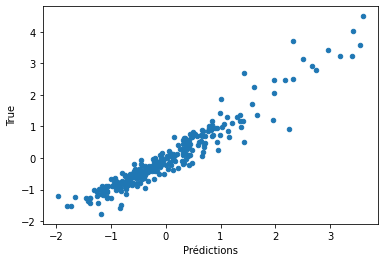

In [24]:
plt.figure(figsize=(7,7))
df_pred.plot(x = "Prédictions", y = "True", kind = "scatter");